In [9]:
import pandas as pd

In [10]:
df=pd.read_csv('segmentation_data_cleaned.csv')

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator

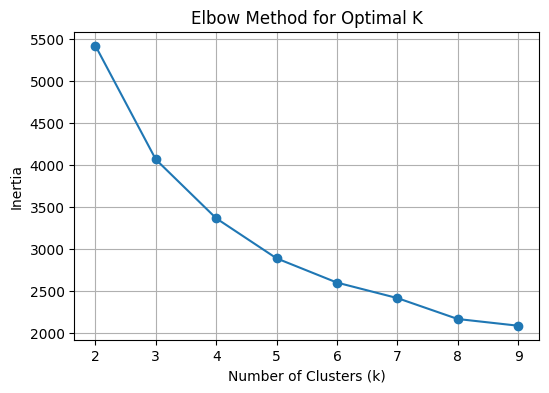

Optimal number of clusters (K) detected by Elbow Method: 5


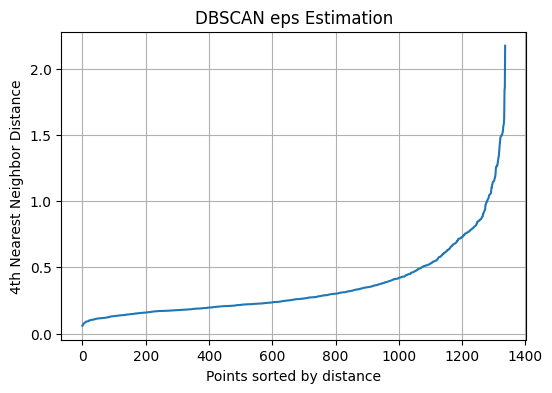

           Model  Num Clusters  Silhouette Score  Davies-Bouldin Index  \
0        K-Means             5            0.3285                1.2047   
1  Agglomerative             5            0.3261                1.2402   
2         DBSCAN            14            0.3973                0.9946   

   Calinski-Harabasz Index  
0                 592.3431  
1                 544.3118  
2                 402.0451  


In [12]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

inertia = []
k_range = range(2, 10)
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(df_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.xticks(k_range)
plt.grid(True)
plt.show()

knee = KneeLocator(k_range, inertia, curve='convex', direction='decreasing')
optimal_k = knee.knee
print(f"Optimal number of clusters (K) detected by Elbow Method: {optimal_k}")

neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(df_scaled)
distances, _ = neighbors_fit.kneighbors(df_scaled)
distances = np.sort(distances[:, 4])

plt.figure(figsize=(6, 4))
plt.plot(distances)
plt.xlabel('Points sorted by distance')
plt.ylabel('4th Nearest Neighbor Distance')
plt.title('DBSCAN eps Estimation')
plt.grid(True)
plt.show()

eps_value = 1.5
min_samples_value = 5

models = {
    'K-Means': KMeans(n_clusters=optimal_k, random_state=42),
    'Agglomerative': AgglomerativeClustering(n_clusters=optimal_k),
    'DBSCAN': DBSCAN(eps=eps_value, min_samples=min_samples_value)
}
labels_dict={}

results = []

for model_name, model in models.items():
    labels = model.fit_predict(df_scaled)
    labels_dict[model_name] = labels
    
    if model_name == 'DBSCAN':
        mask = labels != -1
        n_clusters = len(set(labels[mask]))
        if n_clusters <= 1:
            sil_score = np.nan
            db_index = np.nan
            ch_score = np.nan
        else:
            sil_score = silhouette_score(df_scaled[mask], labels[mask])
            db_index = davies_bouldin_score(df_scaled[mask], labels[mask])
            ch_score = calinski_harabasz_score(df_scaled[mask], labels[mask])
    else:
        n_clusters = len(set(labels))
        sil_score = silhouette_score(df_scaled, labels)
        db_index = davies_bouldin_score(df_scaled, labels)
        ch_score = calinski_harabasz_score(df_scaled, labels)
    
    results.append({
        'Model': model_name,
        'Num Clusters': n_clusters,
        'Silhouette Score': round(sil_score, 4),
        'Davies-Bouldin Index': round(db_index, 4),
        'Calinski-Harabasz Index': round(ch_score, 4)
    })
    

results_df = pd.DataFrame(results)
print(results_df)


In [13]:
import joblib


joblib.dump(models['K-Means'], 'kmeans_model.pkl')
joblib.dump(models['Agglomerative'], 'agglo_model.pkl')
joblib.dump(models['DBSCAN'], 'dbscan_model.pkl')

joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']

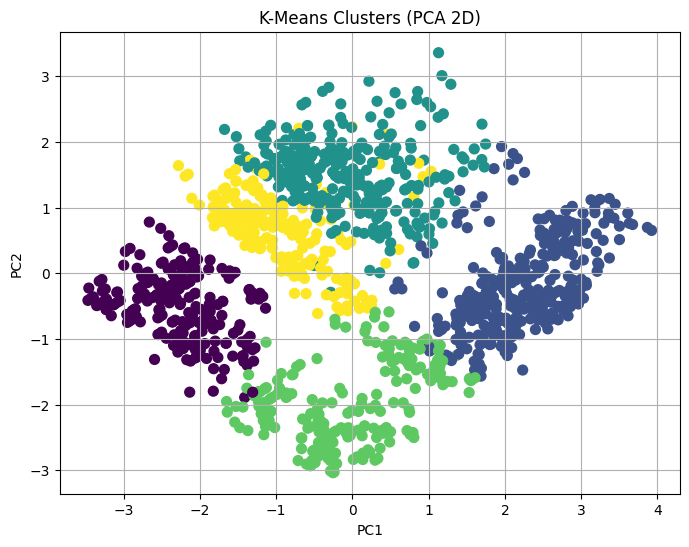

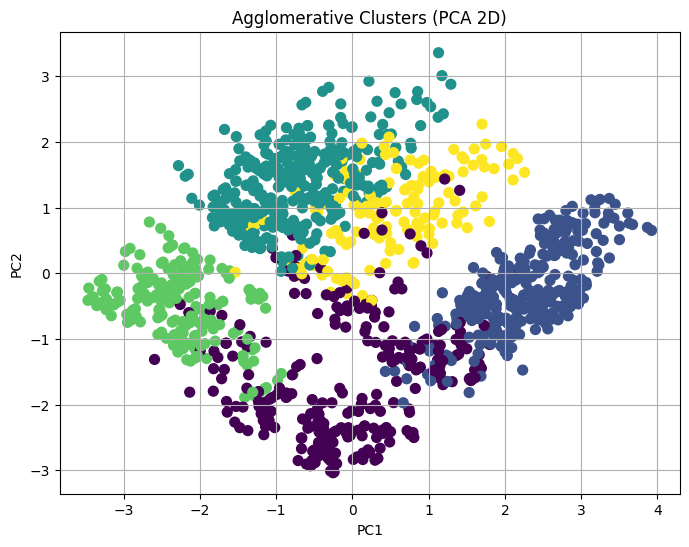

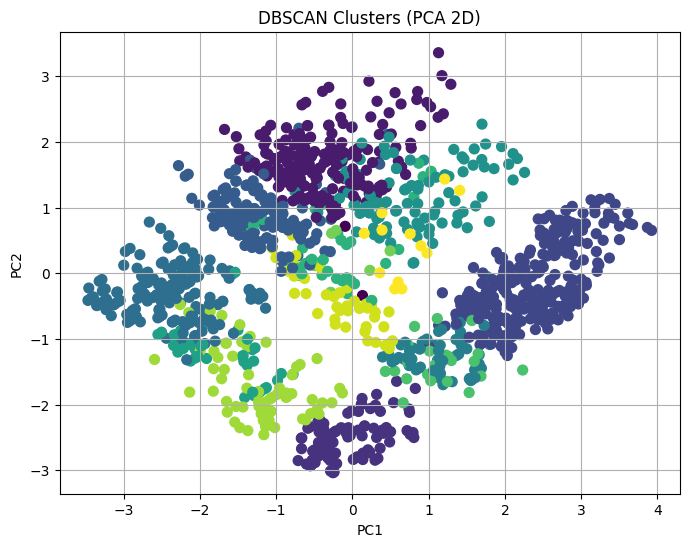

In [14]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

for model_name, model in models.items():
    labels = model.labels_ if hasattr(model, 'labels_') else model.fit_predict(df_scaled)  # DBSCAN may not have labels_
    plt.figure(figsize=(8, 6))
    plt.scatter(df_pca[:, 0], df_pca[:, 1], c=labels, cmap='viridis', s=50)
    plt.title(f'{model_name} Clusters (PCA 2D)')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.grid(True)
    plt.show()


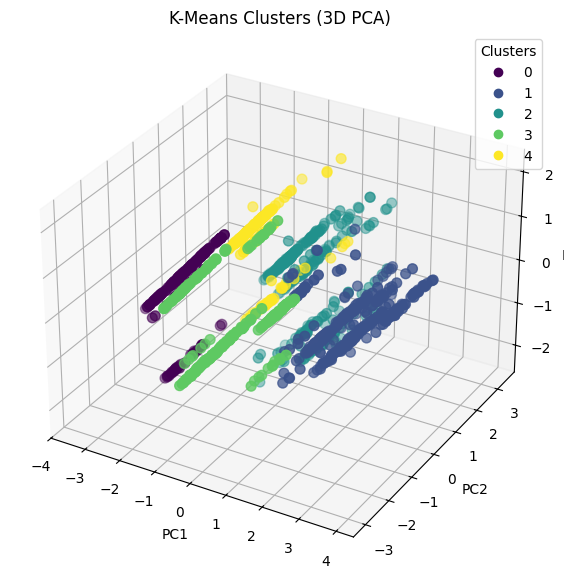

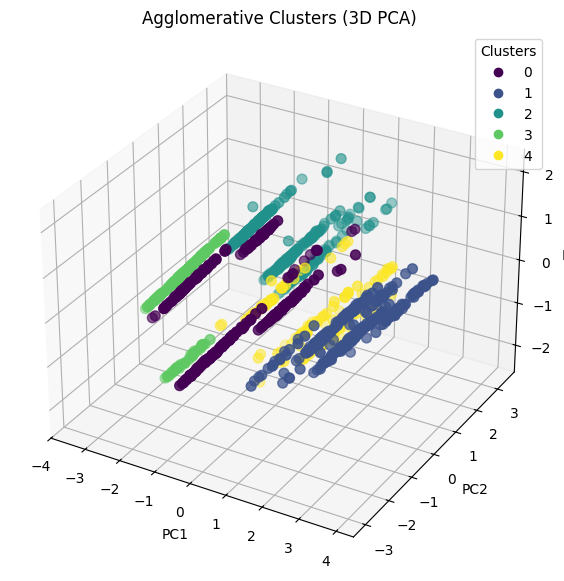

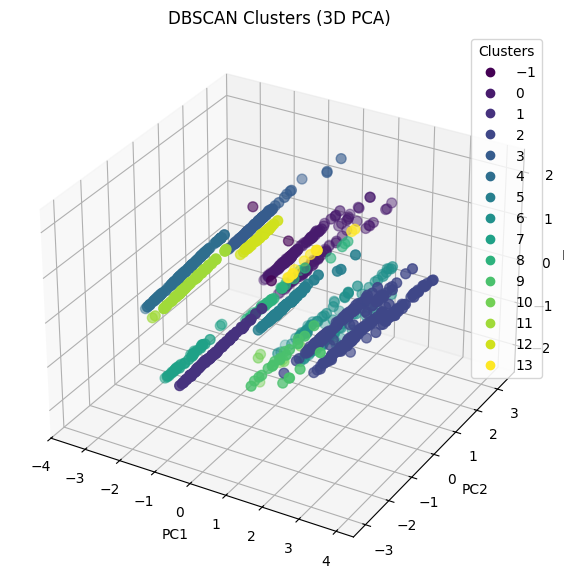

In [15]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca_3d = PCA(n_components=3)
df_pca_3d = pca_3d.fit_transform(df_scaled)

for model_name, labels in labels_dict.items():
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    
    scatter = ax.scatter(
        df_pca_3d[:, 0],
        df_pca_3d[:, 1],
        df_pca_3d[:, 2],
        c=labels,
        cmap='viridis',
        s=50
    )
    
    
    ax.set_title(f"{model_name} Clusters (3D PCA)")
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    plt.legend(*scatter.legend_elements(), title="Clusters")
    plt.show()


In [16]:
import mlflow
import mlflow.sklearn
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

mlflow.set_experiment("clustering_with graph by r")

results = []


pca_2d = PCA(n_components=2)
df_pca_2d = pca_2d.fit_transform(df_scaled)

pca_3d = PCA(n_components=3)
df_pca_3d = pca_3d.fit_transform(df_scaled)

for model_name, model in models.items():
    
    labels = model.labels_ if hasattr(model, 'labels_') else model.fit_predict(df_scaled)

    mlflow.end_run()  
    with mlflow.start_run(run_name=model_name):

        if model_name == "DBSCAN":
            mask = labels != -1
            if len(set(labels[mask])) <= 1:
                sil_score = None
                db_index = None
                ch_score = None
                n_clusters = 0
            else:
                sil_score = silhouette_score(df_scaled[mask], labels[mask])
                db_index = davies_bouldin_score(df_scaled[mask], labels[mask])
                ch_score = calinski_harabasz_score(df_scaled[mask], labels[mask])
                n_clusters = len(set(labels[mask]))
        else:
            sil_score = silhouette_score(df_scaled, labels)
            db_index = davies_bouldin_score(df_scaled, labels)
            ch_score = calinski_harabasz_score(df_scaled, labels)
            n_clusters = len(set(labels))

   
        results.append([model_name, n_clusters, sil_score, db_index, ch_score])

        
        mlflow.log_metrics({
            'Num Clusters': n_clusters,
            'Silhouette Score': sil_score,
            'Davies-Bouldin Index': db_index,
            'Calinski-Harabasz Index': ch_score
        })

      
        mlflow.log_param("model_name", model_name)
        if model_name in ["K-Means", "Agglomerative"]:
            mlflow.log_param("n_clusters", n_clusters)
        elif model_name == "DBSCAN":
            mlflow.log_param("eps", eps_value)
            mlflow.log_param("min_samples", min_samples_value)

       
        mlflow.sklearn.log_model(model, artifact_path=model_name)
        mlflow.sklearn.log_model(scaler, "scaler")

        plt.figure(figsize=(8, 6))
        plt.scatter(df_pca_2d[:, 0], df_pca_2d[:, 1], c=labels, cmap='viridis', s=50)
        plt.title(f'{model_name} Clusters (PCA 2D)')
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.grid(True)
        artifact_file_2d = f"{model_name}_clusters_2d.png"
        plt.savefig(artifact_file_2d)
        mlflow.log_artifact(artifact_file_2d)
        plt.close()

        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(
            df_pca_3d[:, 0],
            df_pca_3d[:, 1],
            df_pca_3d[:, 2],
            c=labels,
            cmap='viridis',
            s=50
        )
        ax.set_title(f'{model_name} Clusters (PCA 3D)')
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.set_zlabel('PC3')
        plt.legend(*scatter.legend_elements(), title="Clusters")
        artifact_file_3d = f"{model_name}_clusters_3d.png"
        plt.savefig(artifact_file_3d)
        mlflow.log_artifact(artifact_file_3d)
        plt.close()

        print(f"{model_name}: metrics, 2D and 3D visualizations logged in MLflow.")


results_df = pd.DataFrame(results, columns=['Model', 'Num Clusters', 'Silhouette Score', 
                                            'Davies-Bouldin Index', 'Calinski-Harabasz Index'])
print("\nResults:\n", results_df)

results_df = results_df.sort_values(by="Silhouette Score", ascending=False)
print("\nSorted by Silhouette Score:\n", results_df)


2025/09/16 11:33:39 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/16 11:33:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/09/16 11:33:43 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/16 11:33:44 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/09/16 11:33:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/09/16 11:33:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


K-Means: metrics, 2D and 3D visualizations logged in MLflow.


2025/09/16 11:33:48 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/09/16 11:33:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/09/16 11:33:51 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/16 11:33:51 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/09/16 11:33:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/09/16 11:33:55 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Agglomerative: metrics, 2D and 3D visualizations logged in MLflow.


2025/09/16 11:33:55 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/09/16 11:33:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/09/16 11:33:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/16 11:33:58 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/09/16 11:34:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


DBSCAN: metrics, 2D and 3D visualizations logged in MLflow.

Results:
            Model  Num Clusters  Silhouette Score  Davies-Bouldin Index  \
0        K-Means             5          0.328510              1.204667   
1  Agglomerative             5          0.326132              1.240201   
2         DBSCAN            14          0.397278              0.994610   

   Calinski-Harabasz Index  
0               592.343058  
1               544.311787  
2               402.045115  

Sorted by Silhouette Score:
            Model  Num Clusters  Silhouette Score  Davies-Bouldin Index  \
2         DBSCAN            14          0.397278              0.994610   
0        K-Means             5          0.328510              1.204667   
1  Agglomerative             5          0.326132              1.240201   

   Calinski-Harabasz Index  
2               402.045115  
0               592.343058  
1               544.311787  
